In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.exceptions import ConvergenceWarning

import matplotlib.pyplot as plt

In [12]:
data = pd.read_csv('data.csv')
data = data.drop('Unnamed: 32', axis = 1)
data = data.drop('id', axis = 1)
data['diagnosis'] = data['diagnosis'].map({'M': 1,'B': 0})
data['diagnosis'].value_counts()
data.tail(10)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
559,0,11.51,23.93,74.52,403.5,0.09261,0.10210,0.11120,0.04105,0.1388,...,12.480,37.16,82.28,474.2,0.12980,0.25170,0.3630,0.09653,0.2112,0.08732
560,0,14.05,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,...,15.300,33.17,100.20,706.7,0.12410,0.22640,0.1326,0.10480,0.2250,0.08321
561,0,11.20,29.37,70.67,386.0,0.07449,0.03558,0.00000,0.00000,0.1060,...,11.920,38.30,75.19,439.6,0.09267,0.05494,0.0000,0.00000,0.1566,0.05905
562,1,15.22,30.62,103.40,716.9,0.10480,0.20870,0.25500,0.09429,0.2128,...,17.520,42.79,128.70,915.0,0.14170,0.79170,1.1700,0.23560,0.4089,0.14090
563,1,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,0.2149,...,24.290,29.41,179.10,1819.0,0.14070,0.41860,0.6599,0.25420,0.2929,0.09873
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.22160,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.16280,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.14180,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.26500,0.4087,0.12400
568,0,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.00000,0.2871,0.07039


In [13]:
X = data.drop('diagnosis', axis = 1).values
y = data['diagnosis'].values

In [14]:
# Normalizing data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [15]:
# Compute the SVD
U, s, Vt = np.linalg.svd(X) 

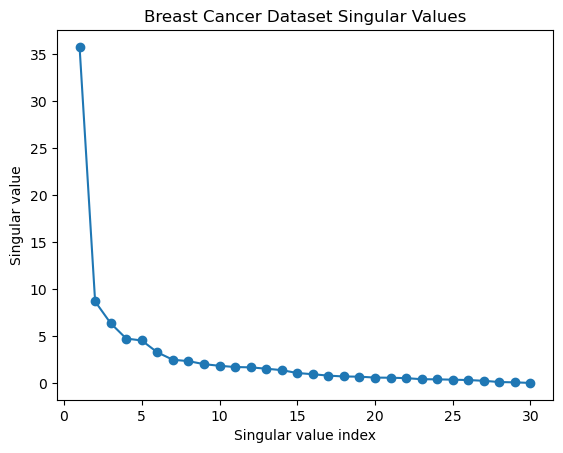

In [20]:
# Plot the singular values
fig, ax = plt.subplots()
ax.plot(range(1, len(s)+1, 1), s, 'o-')
ax.set_xlabel('Singular value index')
ax.set_ylabel('Singular value')
ax.set_title('Breast Cancer Dataset Singular Values')
plt.show()

In [16]:
svd = TruncatedSVD(n_components = 10, random_state=42)
X_svd = svd.fit_transform(X)
print(X_svd.shape)

(569, 10)


In [17]:
# Split data as train and test using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=128)

In [18]:
def MLP_grid(X_train, X_test, y_train, y_test, X, y):
    # MLP classifier
    mlp = MLPClassifier(max_iter=128, early_stopping=True, random_state=2, 
                        validation_fraction=0.2, n_iter_no_change=10)
    # Define the hyperparameters to search over
    param_grid = {
        'hidden_layer_sizes': [(32, ), (16, ), (8, )],
        'alpha': [0.001, 0.001, 0.1],
        'learning_rate_init': [0.001, 0.01, 0.1],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'batch_size': [8, 16, 32, 64],
        'activation': ['relu', 'tanh', 'logistic', 'identity'],
        'solver': ['adam', 'sgd'],
    }
    
    # Perform grid search to find the best hyperparameters
    grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        grid_search.fit(X_train, y_train)
    
    # Print the best hyperparameters and their score
    print("Best hyperparameters:", grid_search.best_params_)
    print('Test accuracy for the best model:', grid_search.score(X_test, y_test))
    
    clf = MLPClassifier(**grid_search.best_params_, random_state=2, early_stopping=True, 
                        validation_fraction=0.2, n_iter_no_change=10)
    
    from sklearn.model_selection import cross_val_score
    scores_f1 = cross_val_score(clf, X, y, cv=5, scoring='f1')
    scores_accuracy = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    
    from prettytable import PrettyTable
    # Create the table
    t = PrettyTable(['Performance Factor', 'Mean', 'Standard Deviation +/-'])
    t.add_row(['F1 Score', round(scores_f1.mean(), 4), round(scores_f1.std(), 4)])
    t.add_row(['Accuracy', round(scores_accuracy.mean(), 4), round(scores_accuracy.std(), 4)])
    
    print(t)
    
    # Plotting
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.errorbar(['F1 Score', 'Accuracy'], [scores_f1.mean(), scores_accuracy.mean()], 
                yerr=[scores_f1.std(), scores_accuracy.std()], fmt='o', capsize=5, color='blue')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Grid Parameters')
    ax.set_ylim([0.9, 1])
    plt.show()


Best hyperparameters: {'activation': 'relu', 'alpha': 0.1, 'batch_size': 32, 'hidden_layer_sizes': (8,), 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'solver': 'adam'}
Test accuracy for the best model: 0.9574468085106383
+--------------------+--------+------------------------+
| Performance Factor |  Mean  | Standard Deviation +/- |
+--------------------+--------+------------------------+
|      F1 Score      | 0.9645 |         0.0162         |
|      Accuracy      | 0.9737 |         0.0124         |
+--------------------+--------+------------------------+


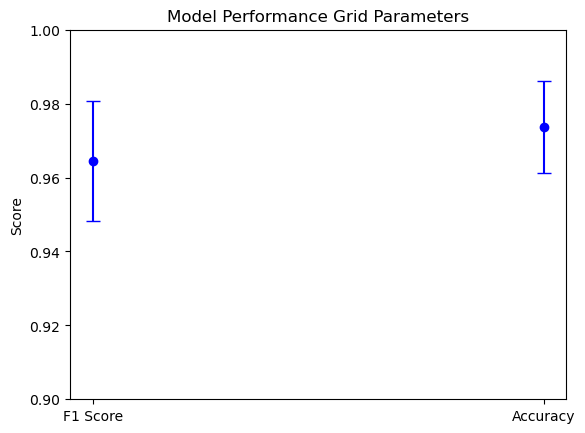

In [19]:
MLP_grid(X_train, X_test, y_train, y_test, X, y)

In [21]:
def MLP_BO(X_train, X_test, y_train, y_test, X, y):
    # MLP classifier
    mlp = MLPClassifier(max_iter=128, early_stopping=True, random_state=2,
                        validation_fraction=0.2, n_iter_no_change=10)
    # Define the search space for the hyperparameters
    search_space = {
        'hidden_layer_sizes': Integer(32, 128, 'log-uniform'),
        'activation': Categorical(['relu', 'tanh', 'logistic']),
        'solver': Categorical(['adam', 'sgd']),
        'alpha': Real(1e-4, 1e-1, 'log-uniform'),
        'learning_rate': Categorical(['constant', 'invscaling', 'adaptive']),
        'learning_rate_init': Real(1e-4, 1e-1, 'log-uniform'),
        'batch_size': Integer(16, 64, 'log-uniform'),
    }
    
    # Perform Bayesian Optimization to find the best hyperparameters
    optimizer = BayesSearchCV(mlp, search_space, cv=5, n_jobs=-1, scoring='accuracy')

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        optimizer.fit(X_train, y_train)
    
    # Print the best set of hyperparameters and the validation accuracy achieved with them
    print("Best set of hyperparameters:", optimizer.best_params_)
    print('Test accuracy of best model:', optimizer.score(X_test, y_test))
    
    clf = MLPClassifier(**optimizer.best_params_, random_state=2, early_stopping=True, 
                        validation_fraction=0.2, n_iter_no_change=10)
    
    from sklearn.model_selection import cross_val_score
    scores_f1 = cross_val_score(clf, X, y, cv=5, scoring='f1')
    scores_accuracy = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    
    from prettytable import PrettyTable
    # Create the table
    t = PrettyTable(['Performance Factor', 'Mean', 'Standard Deviation +/-'])
    t.add_row(['F1 Score', round(scores_f1.mean(), 4), round(scores_f1.std(), 4)])
    t.add_row(['Accuracy', round(scores_accuracy.mean(), 4), round(scores_accuracy.std(), 4)])
    
    print(t)
    
    # Plotting
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.errorbar(['F1 Score', 'Accuracy'], [scores_f1.mean(), scores_accuracy.mean()], 
                yerr=[scores_f1.std(), scores_accuracy.std()], fmt='o', capsize=5, color='blue')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Bayesian Optimization')
    ax.set_ylim([0.9, 1])
    plt.show()


C:\Users\supra\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['tanh', 0.1, 64, 128, 'constant', 0.1, 'adam'] before, using random point ['tanh', 0.025213097570817744, 36, 126, 'adaptive', 0.0010160230379669178, 'sgd']
  warnings.warn(


Best set of hyperparameters: OrderedDict([('activation', 'tanh'), ('alpha', 0.1), ('batch_size', 64), ('hidden_layer_sizes', 128), ('learning_rate', 'constant'), ('learning_rate_init', 0.1), ('solver', 'adam')])
Test accuracy of best model: 0.9627659574468085
+--------------------+--------+------------------------+
| Performance Factor |  Mean  | Standard Deviation +/- |
+--------------------+--------+------------------------+
|      F1 Score      | 0.9507 |         0.0133         |
|      Accuracy      | 0.9631 |         0.0102         |
+--------------------+--------+------------------------+


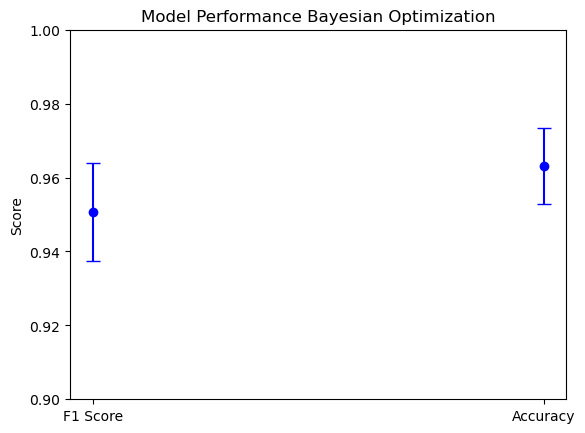

In [22]:
MLP_BO(X_train, X_test, y_train, y_test, X, y)

In [23]:
def MLP_Funnel(X_train, X_test, y_train, y_test, X, y):
    # MLP classifier
    mlp = MLPClassifier(max_iter=128, random_state=2, early_stopping=True, 
                        validation_fraction=0.2, n_iter_no_change=10)
    # Define the hyperparameters to search over (32, 16, 8) overfitting when used cross_validation
    param_grid = {
        'hidden_layer_sizes': [(128, 64, 32), (64, 32, 32, 16), (32, 32, 16), (64, 64, 32, 16)],
        'alpha': [0.001, 0.01, 0.1],
        'learning_rate_init': [0.001, 0.01, 0.1],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'batch_size': [32, 64, 128],
        'activation': ['relu', 'tanh', 'logistic'],
        'solver': ['adam', 'sgd'],
    }
    
    # Perform grid search to find the best hyperparameters
    grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        grid_search.fit(X_train, y_train)
    
    # Print the best hyperparameters and their score
    print("Best hyperparameters:", grid_search.best_params_)
    print('Test accuracy for the best model:', grid_search.score(X_test, y_test))
    
    clf = MLPClassifier(**grid_search.best_params_, random_state=2, early_stopping=True, 
                        validation_fraction=0.2, n_iter_no_change=10)
    
    from sklearn.model_selection import cross_val_score
    scores_f1 = cross_val_score(clf, X, y, cv=5, scoring='f1')
    scores_accuracy = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    
    from prettytable import PrettyTable
    # Create the table
    t = PrettyTable(['Performance Factor', 'Mean', 'Standard Deviation +/-'])
    t.add_row(['F1 Score', round(scores_f1.mean(), 4), round(scores_f1.std(), 4)])
    t.add_row(['Accuracy', round(scores_accuracy.mean(), 4), round(scores_accuracy.std(), 4)])
    
    print(t)
    
    # Plotting
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.errorbar(['F1 Score', 'Accuracy'], [scores_f1.mean(), scores_accuracy.mean()], 
                yerr=[scores_f1.std(), scores_accuracy.std()], fmt='o', capsize=5, color='blue')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Grid Parameters')
    ax.set_ylim([0.9, 1])
    plt.show()


C:\Users\supra\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:412: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)


Best hyperparameters: {'activation': 'relu', 'alpha': 0.001, 'batch_size': 32, 'hidden_layer_sizes': (32, 32, 16), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'solver': 'sgd'}
Test accuracy for the best model: 0.9574468085106383
+--------------------+--------+------------------------+
| Performance Factor |  Mean  | Standard Deviation +/- |
+--------------------+--------+------------------------+
|      F1 Score      | 0.9428 |         0.0125         |
|      Accuracy      | 0.9578 |         0.0102         |
+--------------------+--------+------------------------+


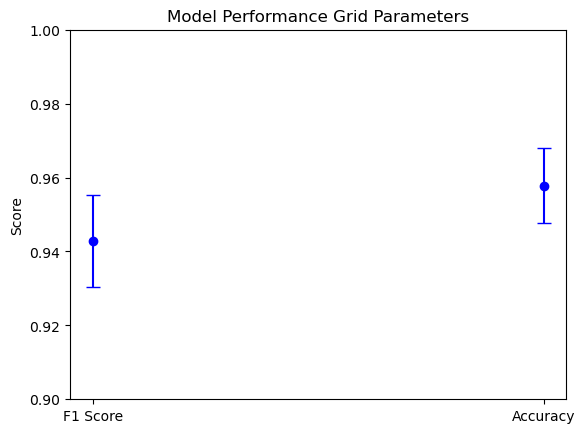

In [24]:
MLP_Funnel(X_train, X_test, y_train, y_test, X, y)

In [25]:
# Split data as train and test using train_test_split
X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(X_svd, y, test_size=0.33, random_state=128)

Best hyperparameters: {'activation': 'relu', 'alpha': 0.001, 'batch_size': 16, 'hidden_layer_sizes': (8,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'solver': 'sgd'}
Test accuracy for the best model: 0.9148936170212766
+--------------------+--------+------------------------+
| Performance Factor |  Mean  | Standard Deviation +/- |
+--------------------+--------+------------------------+
|      F1 Score      | 0.9636 |         0.0212         |
|      Accuracy      | 0.9737 |         0.0147         |
+--------------------+--------+------------------------+


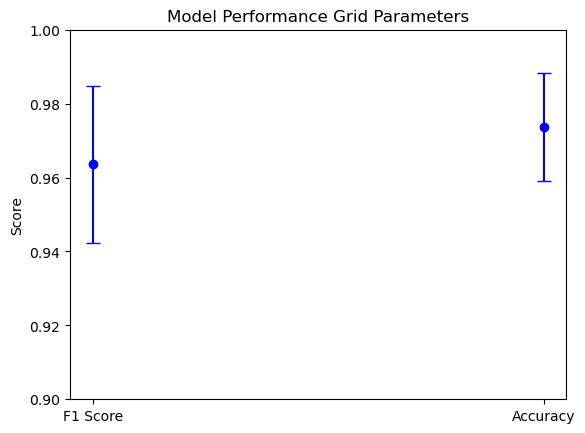

In [26]:
MLP_grid(X_train_svd, X_test_svd, y_train_svd, y_test_svd, X_svd, y)

Best set of hyperparameters: OrderedDict([('activation', 'relu'), ('alpha', 0.0001), ('batch_size', 64), ('hidden_layer_sizes', 32), ('learning_rate', 'invscaling'), ('learning_rate_init', 0.06751523731831686), ('solver', 'adam')])
Test accuracy of best model: 0.973404255319149
+--------------------+--------+------------------------+
| Performance Factor |  Mean  | Standard Deviation +/- |
+--------------------+--------+------------------------+
|      F1 Score      | 0.9405 |         0.0191         |
|      Accuracy      | 0.956  |         0.0149         |
+--------------------+--------+------------------------+


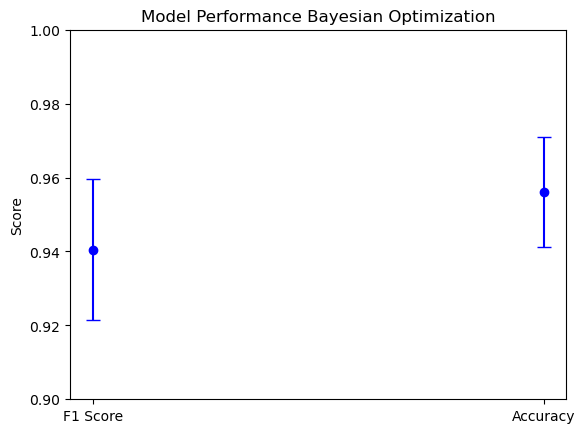

In [27]:
MLP_BO(X_train_svd, X_test_svd, y_train_svd, y_test_svd, X_svd, y)

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define a pipeline to scale features and then apply MLPClassifier
scaler = StandardScaler()
mlp = MLPClassifier(max_iter=300, random_state=2, early_stopping=True, 
                    validation_fraction=0.2, n_iter_no_change=15)  # Increased max_iter and patience

pipeline = Pipeline([
    ('scaler', scaler),
    ('mlp', mlp)
])

# Updated param_grid with funnel structure, regularization, and learning rate optimization
param_grid = {
    'mlp__hidden_layer_sizes': [(128, 64, 32), (64, 32, 16), (64, 64, 32, 16)],  # Funnel structure
    'mlp__alpha': [0.0001, 0.001, 0.01],  # Regularization
    'mlp__learning_rate_init': [0.0001, 0.001, 0.01],  # Lower learning rates
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__batch_size': [32, 64],  # Moderate batch sizes
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'sgd']
}

# Use this pipeline and param_grid in your GridSearchCV setup
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')


In [31]:

# Setting up the MLP classifier with cross-validation
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
cv_scores = cross_val_score(mlp, X, y, cv=5, scoring='accuracy')

# Print cross-validation results
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("Standard Deviation of CV Accuracy:", np.std(cv_scores))

C:\Users\supra\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\supra\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\supra\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\supra\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.wa

Cross-Validation Accuracy Scores: [0.98245614 0.96491228 0.97368421 0.97368421 0.99115044]
Mean CV Accuracy: 0.9771774569166279
Standard Deviation of CV Accuracy: 0.008921310582673642


C:\Users\supra\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


C:\Users\supra\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\supra\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\supra\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\supra\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.wa

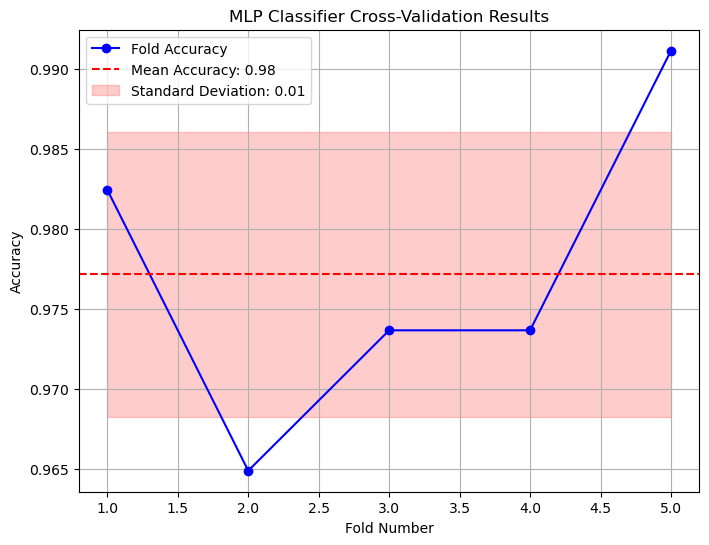

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

# Initialize the classifier and perform cross-validation
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
cv_scores = cross_val_score(mlp, X, y, cv=5, scoring='accuracy')

# Plotting the cross-validation results
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='-', color='b', label='Fold Accuracy')
plt.axhline(np.mean(cv_scores), color='r', linestyle='--', label=f'Mean Accuracy: {np.mean(cv_scores):.2f}')
plt.fill_between(range(1, len(cv_scores) + 1),
                 np.mean(cv_scores) - np.std(cv_scores),
                 np.mean(cv_scores) + np.std(cv_scores),
                 color='r', alpha=0.2, label=f'Standard Deviation: {np.std(cv_scores):.2f}')

# Adding labels and title
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('MLP Classifier Cross-Validation Results')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\supra\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 800x600 with 0 Axes>

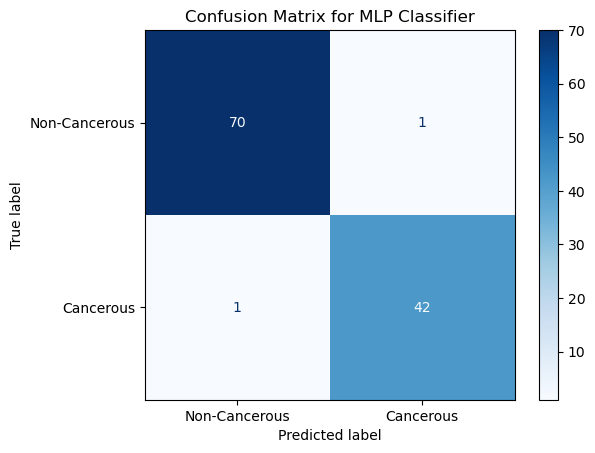

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for MLP Classifier')
plt.show()
